In [ ]:
import zipfile
import os

# Define the ZIP file name (replace with your filename)
zip_file_name = "Rice_Image_Dataset.zip"  # Replace with the actual name

# Unzip the file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall("/content/Rice_Image_Dataset")  # Unzips to this directory

# Confirm the extraction
os.listdir("/content/Rice_Image_Dataset")


['Rice_Image_Dataset']

In [ ]:
base_dir = "/content/Rice_Image_Dataset/Rice_Image_Dataset"
# List the folder's name of Dataset
categories = os.listdir(base_dir)
categories.remove('Rice_Citation_Request.txt')
categories

['Arborio', 'Karacadag', 'Basmati', 'Jasmine', 'Ipsala']

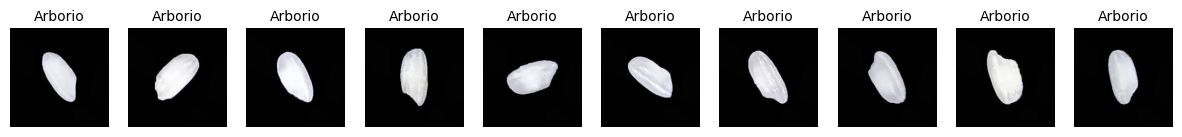

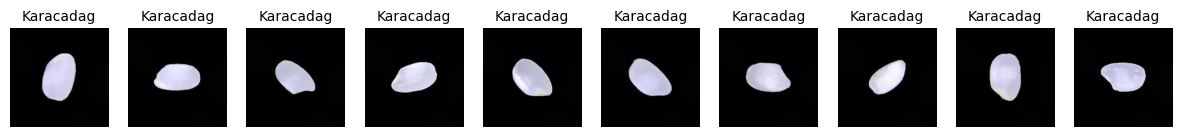

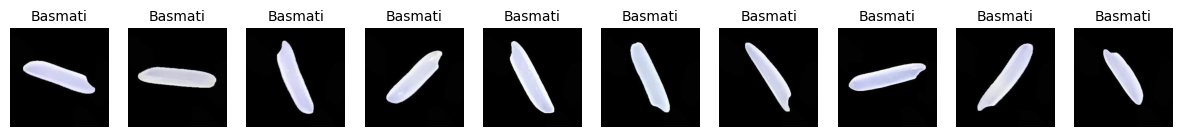

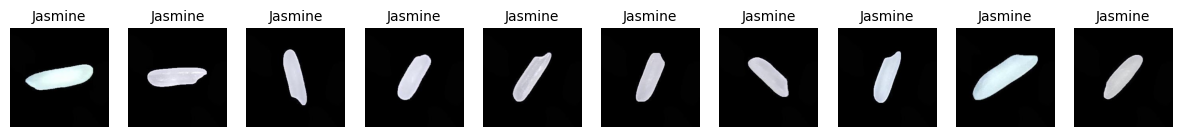

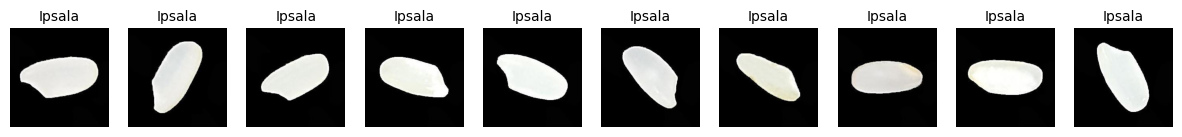

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Number of images to display per category
num_images = 10

# Display first 5 images from each category
for category in categories:
    category_path = os.path.join(base_dir, category)
    image_files = os.listdir(category_path)[:num_images]  # Get first 5 images

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, image_file in enumerate(image_files):
        # Load the image
        image_path = os.path.join(category_path, image_file)
        image = Image.open(image_path)

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(category, fontsize=10)  # Display category above each image
        axes[i].axis('off')

    plt.show()


In [ ]:
for category in categories:
  print(category)

Arborio
Karacadag
Basmati
Jasmine
Ipsala


In [ ]:
import pandas as pd
import os

# Initialize lists to store image paths and categories
image_paths = []
categories = []

# Loop through each category folder
for category in os.listdir(base_dir):
    category_path = os.path.join(base_dir, category)

    # Ensure it's a folder
    if os.path.isdir(category_path):
        # Loop through each image in the category folder
        for image_file in os.listdir(category_path):
            image_path = os.path.join(category_path, image_file)
            image_paths.append(image_path)  # Save the image path
            categories.append(category)     # Save the category name

# Create a DataFrame
df = pd.DataFrame({
    'image': image_paths,
    'category': categories
})
# Initialize an empty DataFrame
df_small = pd.DataFrame()

# Loop through each category and sample 1500 images
for category in df['category'].unique():
    category_df = df[df['category'] == category].sample(n=1500, random_state=42, replace=False)
    df_small = pd.concat([df_small, category_df])

# Reset the index for convenience
# Shuffle the DataFrame
df_small = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

# Display the first few rows to verify
df_small.head()
print(len(df_small))

train = df_small[:int(7500*0.8)]
validation = df_small[6000:6750]
test = df_small[6750:]
print(len(train))
print(len(validation))
print(len(test))

7500
6000
750
750


In [ ]:
# Import necessary libraries
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ensure category labels are strings
df_small['category'] = df_small['category'].astype(str)

# Define image size and batch size
img_height, img_width = 128, 128  # Resize during loading to save memory
batch_size = 16

# Initialize the generator
datagen = ImageDataGenerator(rescale=1./255)  # Normalize to [0, 1]

# Create training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train,
    x_col='image',
    y_col='category',
    target_size=(img_height, img_width),  # Resize images while loading
    batch_size=batch_size,
    class_mode='categorical'
)

# Create validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=validation,
    x_col='image',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Create test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Confirm generator setup
print("Training classes:", train_generator.class_indices)
print("Validation classes:", validation_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Found 6000 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Found 750 validated image filenames belonging to 5 classes.
Training classes: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Validation classes: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}
Test classes: {'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}


In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(train_generator.class_indices), activation='softmax')

])

# Display the model summary
# model.summary()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.7712 - loss: 0.5850 - val_accuracy: 0.9600 - val_loss: 0.1383
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.9349 - loss: 0.1913 - val_accuracy: 0.9600 - val_loss: 0.1120
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9426 - loss: 0.1517 - val_accuracy: 0.9667 - val_loss: 0.0902
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.9522 - loss: 0.1447 - val_accuracy: 0.9573 - val_loss: 0.1179
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.9608 - loss: 0.1155 - val_accuracy: 0.9613 - val_loss: 0.1106
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9602 - loss: 0.0816
Test Accuracy: 0.9666666388511658
Test Loss: 0.0828854888677597


In [ ]:
import numpy as np


# Calculate percentage of correct predictions for each category
class_indices = test_generator.class_indices
class_labels = list(class_indices.keys())

# Collect predictions and true labels batch-by-batch to ensure alignment
y_true = []
y_pred = []

for images, labels in test_generator:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))  # Predicted class indices
    y_true.extend(np.argmax(labels, axis=1))  # True class indices (one-hot to label index)

    if len(y_true) >= test_generator.samples:  # Stop when all samples are processed
        break

y_true = np.array(y_true)
y_pred = np.array(y_pred)


# Calculate accuracy per class
accuracy_per_class = {}
for i, label in enumerate(class_labels):
    class_indices = [index for index, value in enumerate(y_true) if value == i]


    if len(class_indices) > 0:  # Only calculate if there are samples of that class
        class_accuracy = np.mean(y_pred[class_indices] == i)
    else:
        class_accuracy = 0  # Avoid NaN if no samples of that class
    accuracy_per_class[label] = class_accuracy * 100


# Display accuracy for each class
for label, accuracy in accuracy_per_class.items():
    print(f"Accuracy for {label}: {accuracy:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

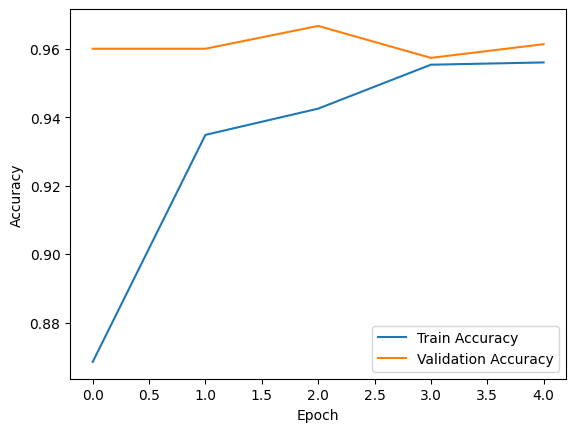

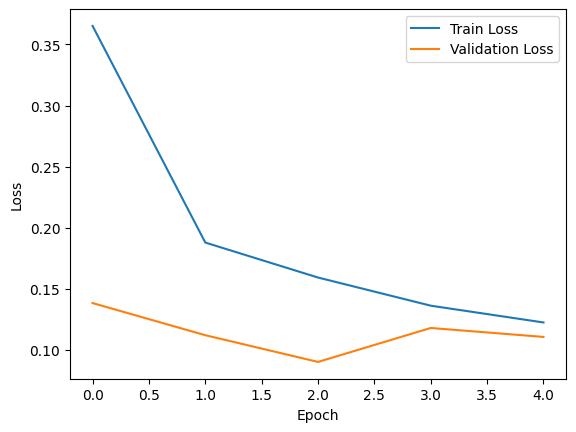

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


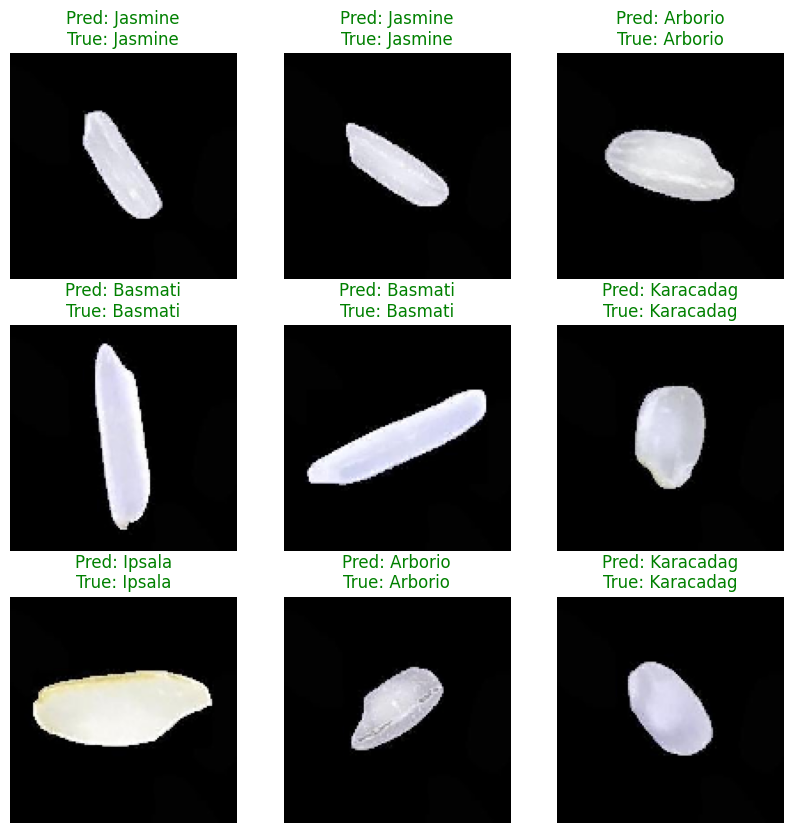

In [ ]:
import random

# Collect all test images and labels
test_images = []
test_labels = []
for images, labels in test_generator:
    test_images.extend(images)
    test_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot encoded labels to indices
    if len(test_images) >= test_generator.samples:
        break

# Convert to numpy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)


# Predict all test images
predictions = model.predict(test_images)
y_pred = np.argmax(predictions, axis=1)

# Randomly select 9 images
random_indices = random.sample(range(len(test_images)), 9)

# Display the images with predictions
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    image = test_images[idx]
    true_label = class_labels[test_labels[idx]]
    pred_label = class_labels[y_pred[idx]]

    plt.subplot(3, 3, i + 1)
    plt.imshow(image)  # Image is already scaled to [0, 1]
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='green' if pred_label == true_label else 'red')
    plt.axis('off')

plt.show()
